# Programming Project #5: Video Stitching and Processing 

## CS445: Computational Photography - Fall 2019

### Part I: Stitch two key frames <img src="images/project_5/image005.jpg" alt="Drawing" style="float: right; width: 450px"/>

#### This involves:
1. compute homography H between two frames; 
2. project each frame onto the same surface;
3. blend the surfaces.



Check that your homography is correct by plotting four points that form a square in frame 270 and their projections in each image, like this:
<p>
    <img src="images/project_5/image002.jpg" alt="Drawing"/>
    <img src="images/project_5/image004.jpg" alt="Drawing"/>
</p>

In [1]:
import cv2
import numpy as np
from numpy.linalg import svd, inv

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# images location
im1 = './images/input/frames/f0450.jpg'
im2 = './images/input/frames/f0270.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread(im2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

In [3]:
def auto_homography(Ia,Ib, homography_func=None):
    '''
    Computes a homography that maps points from Ia to Ib

    Input: Ia and Ib are images
    Output: H is the homography

    '''
    if Ia.dtype == 'float32' and Ib.dtype == 'float32':
        Ia = (Ia*255).astype(np.uint8)
        Ib = (Ib*255).astype(np.uint8)
    
    Ia_gray = cv2.cvtColor(Ia,cv2.COLOR_BGR2GRAY)
    Ib_gray = cv2.cvtColor(Ib,cv2.COLOR_BGR2GRAY)

    # Initiate SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
    
    # find the keypoints and descriptors with SIFT
    kp_a, des_a = sift.detectAndCompute(Ia_gray,None)
    kp_b, des_b = sift.detectAndCompute(Ib_gray,None)    
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_a,des_b, k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
   
    numMatches = int(len(good))

    matches = good

    # Xa and Xb are 3xN matrices that contain homogeneous coordinates for the N
    # matching points for each image
    Xa = np.ones((3,numMatches))
    Xb = np.ones((3,numMatches))
    
    for idx, match_i in enumerate(matches):
        Xa[:,idx][0:2] = kp_a[match_i.queryIdx].pt
        Xb[:,idx][0:2] = kp_b[match_i.trainIdx].pt

    ## RANSAC
    niter = 1000
    best_score = 0

    for t in range(niter):
        # estimate homography
        subset = np.random.choice(numMatches, 4, replace=False)
        pts1 = Xa[:,subset]
        pts2 = Xb[:,subset]
        
        H_t = homography_func(pts1, pts2) # edit helper code below (computeHomography)

        # score homography
        Xb_ = np.dot(H_t, Xa) # project points from first image to second using H
        du = Xb_[0,:]/Xb_[2,:] - Xb[0,:]/Xb[2,:]
        dv = Xb_[1,:]/Xb_[2,:] - Xb[1,:]/Xb[2,:]

        ok_t = np.sqrt(du**2 + dv**2) < 5  # you may need to play with this threshold
        score_t = sum(ok_t)

        if score_t > best_score:
            best_score = score_t
            H = H_t
            in_idx = ok_t
    
    print('best score: {:02f}'.format(best_score))

    # Optionally, you may want to re-estimate H based on inliers

    return H

In [4]:
def computeHomography(pts1, pts2):
    '''
    Compute homography that maps from pts1 to pts2 using least squares solver
     
    Input: pts1 and pts2 are 3xN matrices for N points in homogeneous
    coordinates. 
    
    Output: H is a 3x3 matrix, such that pts2~=H*pts1
    '''
    N = pts1.shape[1]
    A = np.zeros((2*N,9))
    
    for i in range(N):
        x = pts1[:, i]
        x_p = pts2[:, i]
        u,v = x[0], x[1]
        u_p,v_p = x_p[0], x_p[1]
        A[2*i,:] = np.array([-u, -v, -1, 0, 0, 0, u*u_p, v*u_p, u_p])
        A[2*i+1, :] = np.array([0, 0, 0, -u, -v, -1, u*v_p, v*v_p, v_p])
    
    _,_,V = np.linalg.svd(A)
    h = V[V.shape[0]-1,:]
    H_n = np.reshape(h, (3,3))
    return H_n

In [5]:
H = auto_homography(im2,im1, computeHomography)

best score: 224.000000


In [6]:
ht, wd, num_channels = 450,800,3
corners, H_t, out = np.zeros((3,4)), np.identity(3), np.zeros((450,800,3))
corners_t = H@(np.array([[0, 0, 1], [360, 0, 1], [0, 480, 1], [360, 480, 1]])).T
corners[0],corners[1] = corners_t[0]/corners_t[2], corners_t[1]/corners_t[2]
H_t[0][2],H_t[1][2] = -1*min(corners[0]), -1*min(corners[1])
img_warped1, img_warped2= cv2.warpPerspective(im1, H_t, (800, 450)), cv2.warpPerspective(im2, H_t.dot(H), (800, 450))

zero_row, zero_col = np.where(np.any(img_warped2 == [0,0,0], axis=-1))
non_row, non_col = np.where(np.any(img_warped2 != [0,0,0], axis=-1))
out[zero_row,zero_col] = img_warped1[zero_row,zero_col]
out[non_row,non_col] = img_warped2[non_row,non_col]

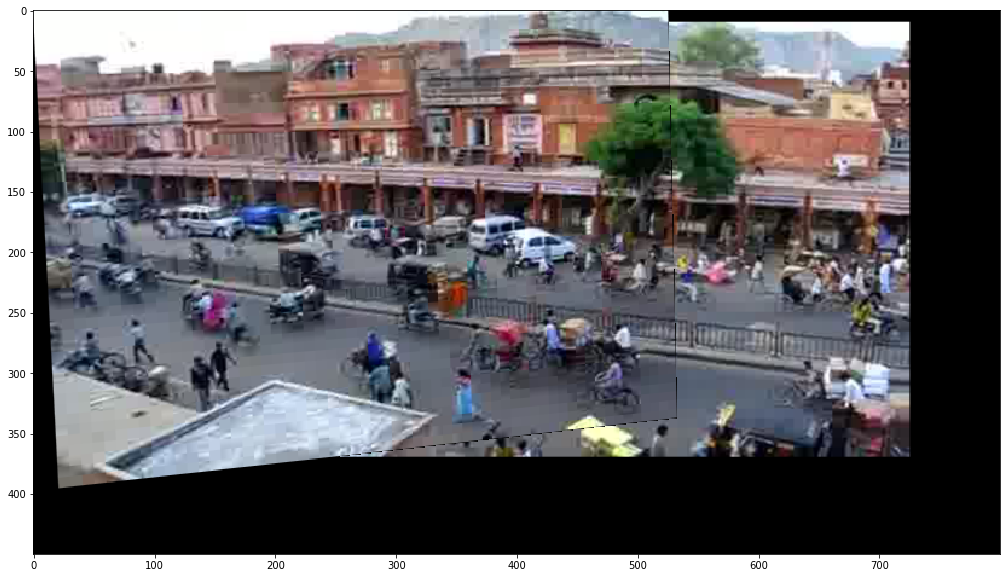

In [9]:
plt.figure(figsize=(60,10))
plt.imshow(out/255)

### Part II: Panorama using five key frames

In this part you will produce a panorama using five key frames. Let's determine frames [90, 270, 450, 630, 810] as key frames. The goal is to map all the five frames onto the plane corresponding to frame 450 (that we also call the _reference frame_). For the frames 270 and 630 you can follow the instructions in part 1.

<img src="images/project_5/header.jpg" alt="Drawing" style="float: center; width: 500px"/>

Mapping frame 90 to frame 450 is difficult because they share very little area. Therefore you need to perform a two stage mapping by using frame 270 as a guide. Compute one projection from 90 to 270 and one from 270 to 450 and multiply the two matrices. This produces a projection from 90 to 450 even though these frames have very little area in common



In [10]:
import cv2
import numpy as np

In [11]:
master_frames =[90, 270, 450, 630, 810]
reference_frame = 450
reference_idx = master_frames.index(reference_frame)

# images location
im1 = './images/input/frames/f0090.jpg'
im2 = './images/input/frames/f0270.jpg'
im3 = './images/input/frames/f0450.jpg'
im4 = './images/input/frames/f0630.jpg'
im5 = './images/input/frames/f0810.jpg'

# Load an color image in grayscale
im1 = cv2.imread(im1)
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)

im2 = cv2.imread(im2)
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)

im3 = cv2.imread(im3)
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2RGB)

im4 = cv2.imread(im4)
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2RGB)

im5 = cv2.imread(im5)
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2RGB)


In [12]:
def createOutput2(frame450, h270, frame270, h90, frame90, h630, frame630, h810, frame810):
    h1, w1, _ = im1.shape
    
    corners = np.array([[0, 0, 1], [360, 0, 1], [0, 480, 1], [360, 480, 1]])
    corners_t = h90@corners.T
    holder = np.zeros((3,4))
    holder[0] = corners_t[0]/corners_t[2]
    holder[1] = corners_t[1]/corners_t[2]
    H_t = computeTranslation(holder)
    
    img_warped2 = cv2.warpPerspective(frame90, H_t.dot(h90), (1600, 600))
    img_warped3 = cv2.warpPerspective(frame270, H_t.dot(h270), (1600, 600))
    img_warped4 = cv2.warpPerspective(frame630, H_t.dot(h630), (1600, 600))
    img_warped5 = cv2.warpPerspective(frame810, H_t.dot(h810), (1600, 600))
    
    img_warped = cv2.warpPerspective(frame450, H_t, (1600,600))
    out = np.zeros((600,1600,3))
    h, w, _ = img_warped.shape
    for r in range(h):
        for c in range(w):
            out[r][c] = img_warped2[r][c]
    for r in range(h):
        for c in range(w):
            if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
                out[r][c] = img_warped3[r][c]
    for r in range(h):
        for c in range(w):
            if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
                out[r][c] = img_warped[r][c]
    for r in range(h):
        for c in range(w):
            if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
                out[r][c] = img_warped4[r][c]
    for r in range(h):
        for c in range(w):
            if out[r][c][0] == 0 and out[r][c][1] == 0 and out[r][c][2] == 0:
                out[r][c] = img_warped5[r][c]
    return out/255

best score: 159.000000
best score: 202.000000
best score: 131.000000
best score: 97.000000


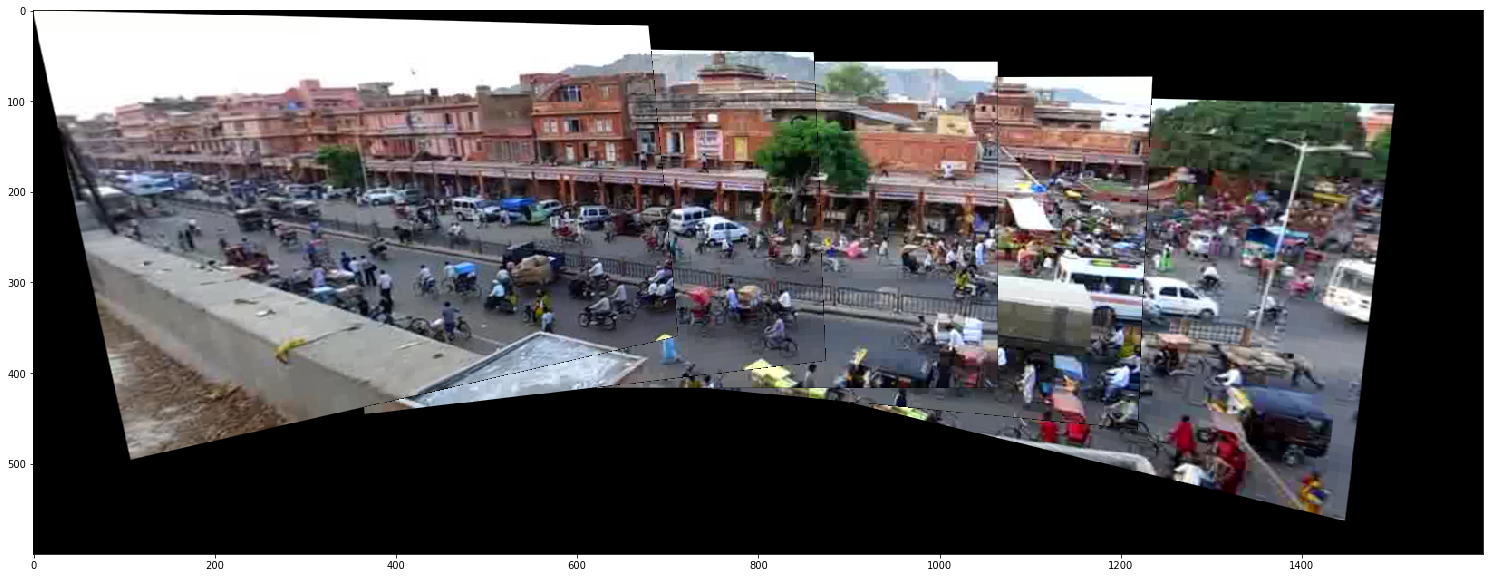

In [13]:
H_1 = auto_homography(im2,im3, computeHomography)

H_2 = auto_homography(im1,im2, computeHomography)
left = np.matmul(H_1, H_2)

H_3 = auto_homography(im4,im3, computeHomography)
H_4 = auto_homography(im5,im4, computeHomography)
right = np.matmul(H_3, H_4)

out = createOutput2(im3, H_1, im2, left, im1, H_3, im4, right, im5)
plt.figure(figsize=(60,10))
plt.imshow(out)



### Part 3: Map the video to the reference plane

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import floor

import utils

In [15]:
dir_frames = 'images/input/frames'
filenames = []
filesinfo = os.scandir(dir_frames)

In [16]:
filenames = [f.path for f in filesinfo if f.name.endswith(".jpg")]
filenames.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

In [17]:
frameCount = len(filenames)
frameHeight, frameWidth, frameChannels = cv2.imread(filenames[0]).shape
frames = np.zeros((frameCount, frameHeight, frameWidth, frameChannels),dtype=np.float32)

In [18]:
for idx, file_i in enumerate(filenames):
    frames[idx] = cv2.cvtColor(cv2.imread(file_i), cv2.COLOR_BGR2RGB) / 255.0
cv2.imwrite('test.jpg', frames[6])

True

In [20]:
## Example usage of utils.projectImage

pastHomographies = np.zeros((len(filenames),len(filenames), 3, 3),dtype=np.float32)
originTranslations = np.zeros((len(filenames), 2), dtype=np.float32)
sourceFrameIndex = 630
referenceFrameIndex = 450

In [21]:
projected = np.zeros((900, 512, 1632, 3), dtype=np.float64)
for i in range(0,450):
    projectedSource, _, originTranslations = utils.projectImage(frames, i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    projected[i] = projectedSource
    
    
    projectedSource, _, originTranslations = utils.projectImage(frames, 899-i, referenceFrameIndex,
                                                            pastHomographies, originTranslations,
                                                            auto_H_func=auto_homography, homography_func=computeHomography, normalization_func=None)
    cv2.imwrite('aligned_frames/a{:04d}.jpg'.format(899-i), cv2.cvtColor(projectedSource, cv2.COLOR_RGB2BGR))
    projected[899-i] = projectedSource

best score: 2630.000000
best score: 29.000000
Overlap:24838
Error:0.0007349351940270817
Finding better homography...
best score: 65.000000
Overlap:40514
Error:0.0005169395142069769
best score: 2751.000000
best score: 261.000000
Overlap:148246
Error:0.00018387441030591066
Found better homography
best score: 32.000000
Overlap:32885
Error:0.0006285090204299022
Finding better homography...
best score: 53.000000
Overlap:58331
Error:0.0004423224492551636
best score: 3035.000000
best score: 134.000000
Overlap:137465
Error:0.00030209901590170146
Found better homography
best score: 26.000000
Overlap:24831
Error:0.000728543845372918
Finding better homography...
best score: 61.000000
Overlap:40554
Error:0.0005142824211242207
best score: 2755.000000
best score: 273.000000
Overlap:148582
Error:0.00018701093539594805
Found better homography
best score: 22.000000
Overlap:32858
Error:0.0006142895429303209
Finding better homography...
best score: 56.000000
Overlap:57788
Error:0.00045197047588114254
bes

best score: 3205.000000
best score: 158.000000
Overlap:147171
Error:0.0002941353544734793
Found better homography
best score: 39.000000
Overlap:26966
Error:0.0007032968588869219
Finding better homography...
best score: 77.000000
Overlap:42779
Error:0.0005221542422592656
best score: 2609.000000
best score: 289.000000
Overlap:148833
Error:0.00017795009886384402
Found better homography
best score: 30.000000
Overlap:40443
Error:0.0005226186579817614
Finding better homography...
best score: 52.000000
Overlap:57481
Error:0.00043065235132382003
best score: 3178.000000
best score: 141.000000
Overlap:148023
Error:0.0002936199822703548
Found better homography
best score: 38.000000
Overlap:29275
Error:0.0007573797754664402
Finding better homography...
best score: 64.000000
Overlap:42483
Error:0.0005220828398716794
best score: 2610.000000
best score: 313.000000
Overlap:149987
Error:0.00017845001314473012
Found better homography
best score: 29.000000
Overlap:41781
Error:0.0005235422631083454
Findin

best score: 56.000000
Overlap:59343
Error:0.00043881233908161393
best score: 3180.000000
best score: 158.000000
Overlap:146583
Error:0.0002937626943855045
Found better homography
best score: 35.000000
Overlap:26032
Error:0.0007758111150407709
Finding better homography...
best score: 68.000000
Overlap:45434
Error:0.00048424425956052677
best score: 2610.000000
best score: 248.000000
Overlap:147228
Error:0.00018847281879601953
Found better homography
best score: 37.000000
Overlap:42920
Error:0.0005120115420268268
Finding better homography...
best score: 68.000000
Overlap:59498
Error:0.0004244140158851713
best score: 3187.000000
best score: 157.000000
Overlap:145323
Error:0.00029815579125338327
Found better homography
best score: 41.000000
Overlap:25332
Error:0.0007614045799311734
Finding better homography...
best score: 63.000000
Overlap:46640
Error:0.0004738932939842411
best score: 2449.000000
best score: 253.000000
Overlap:145427
Error:0.0001884332470527691
Found better homography
best 

best score: 31.000000
Overlap:43597
Error:0.0005472648775177836
Finding better homography...
best score: 59.000000
Overlap:64577
Error:0.0004465794257812896
best score: 3015.000000
best score: 136.000000
Overlap:142554
Error:0.00029594066270638225
Found better homography
best score: 35.000000
Overlap:28182
Error:0.000772123702311765
Finding better homography...
best score: 76.000000
Overlap:52584
Error:0.00046624972756958527
best score: 2602.000000
best score: 239.000000
Overlap:140571
Error:0.00020007686821496727
Found better homography
best score: 47.000000
Overlap:45431
Error:0.0005128234847355112
Finding better homography...
best score: 63.000000
Overlap:66108
Error:0.0004217391173891832
best score: 3191.000000
best score: 165.000000
Overlap:142709
Error:0.0002945680463083904
Found better homography
best score: 40.000000
Overlap:28064
Error:0.0007573001069489734
Finding better homography...
best score: 72.000000
Overlap:52747
Error:0.0004656994455469679
best score: 2558.000000
best

best score: 2687.000000
best score: 263.000000
Overlap:141512
Error:0.00019874522802611647
Found better homography
best score: 41.000000
Overlap:49397
Error:0.000520921341387444
Finding better homography...
best score: 59.000000
Overlap:67789
Error:0.0004446603212841214
best score: 3091.000000
best score: 153.000000
Overlap:143604
Error:0.0003107524004424889
Found better homography
best score: 53.000000
Overlap:31380
Error:0.0006735475882603065
Finding better homography...
best score: 75.000000
Overlap:55766
Error:0.0004588160083826421
best score: 2633.000000
best score: 243.000000
Overlap:142088
Error:0.00020901791203169329
Found better homography
best score: 36.000000
Overlap:49909
Error:0.0005060803313377374
Finding better homography...
best score: 73.000000
Overlap:67793
Error:0.00045046509529705214
best score: 3099.000000
best score: 185.000000
Overlap:145859
Error:0.00029843801510585856
Found better homography


/home/kazukis2/anaconda3/envs/cv3/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/home/kazukis2/anaconda3/envs/cv3/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


best score: 45.000000
Overlap:31526
Error:0.0006814946966892452
Finding better homography...
best score: 72.000000
Overlap:55356
Error:0.00045357909572522805
best score: 2730.000000
best score: 247.000000
Overlap:141055
Error:0.0002001853246681558
Found better homography
best score: 37.000000
Overlap:50635
Error:0.0004972895493937626
Finding better homography...
best score: 56.000000
Overlap:68699
Error:0.0004460862676517574
best score: 3043.000000
best score: 173.000000
Overlap:145765
Error:0.00029964953217860634
Found better homography
best score: 46.000000
Overlap:31729
Error:0.0006696429610603243
Finding better homography...
Overlap:55356
Error:0.00045357936866500235
best score: 247.000000
Overlap:143229
Error:0.00020230680436927295
Found better homography
best score: 46.000000
Overlap:51125
Error:0.000505606520970355
Finding better homography...
Overlap:68699
Error:0.000446086449486709
best score: 154.000000
Overlap:146157
Error:0.00030298602969007954
Found better homography
best 

best score: 3066.000000
best score: 182.000000
Overlap:144780
Error:0.0003086375441813312
Found better homography
best score: 52.000000
Overlap:34428
Error:0.0005898556516531345
Finding better homography...
best score: 75.000000
Overlap:59182
Error:0.00045154867857372414
best score: 2738.000000
best score: 235.000000
Overlap:141131
Error:0.00019548793570724185
Found better homography
best score: 43.000000
Overlap:53559
Error:0.0004956711315833134
Finding better homography...
best score: 64.000000
Overlap:73793
Error:0.00044491795541472923
best score: 3053.000000
best score: 203.000000
Overlap:144504
Error:0.00030567368310337374
Found better homography
best score: 60.000000
Overlap:34366
Error:0.000590703652518262
Finding better homography...
Overlap:59182
Error:0.0004515493599255541
best score: 248.000000
Overlap:141625
Error:0.00019507215624603411
Found better homography
best score: 44.000000
Overlap:54867
Error:0.00045689033330491757
Finding better homography...
Overlap:73793
Error:0

best score: 84.000000
Overlap:77612
Error:0.00042041110072410824
best score: 2901.000000
best score: 165.000000
Overlap:137370
Error:0.00033202263118506235
Found better homography
best score: 65.000000
Overlap:37281
Error:0.0005831817000524305
Finding better homography...
best score: 89.000000
Overlap:61784
Error:0.000444880060527691
best score: 2600.000000
best score: 201.000000
Overlap:141453
Error:0.0001959778318056313
Found better homography
best score: 47.000000
Overlap:54069
Error:0.0004733892306206099
Finding better homography...
best score: 75.000000
Overlap:78956
Error:0.0004190871110427792
best score: 2816.000000
best score: 159.000000
Overlap:136309
Error:0.0003310408909709632
Found better homography
best score: 74.000000
Overlap:38029
Error:0.0005843940220419257
Finding better homography...
Overlap:61784
Error:0.00044488022352369124
best score: 253.000000
Overlap:141487
Error:0.00019408237716698456
Found better homography
best score: 45.000000
Overlap:53971
Error:0.00048096

best score: 55.000000
Overlap:58134
Error:0.00045434940982909904
Finding better homography...
best score: 92.000000
Overlap:83263
Error:0.0004236463878849256
best score: 2873.000000
best score: 163.000000
Overlap:136309
Error:0.00033814397626377696
Found better homography
Overlap:40554
Error:0.0005142838828251271
Finding better homography...
best score: 94.000000
Overlap:65011
Error:0.0004431187666168052
best score: 2699.000000
best score: 225.000000
Overlap:139515
Error:0.0002038349207361237
Found better homography
Overlap:58331
Error:0.0004423235645320248
Finding better homography...
best score: 94.000000
Overlap:83847
Error:0.00042819598775727807
best score: 2804.000000
best score: 166.000000
Overlap:135748
Error:0.0003401258353577929
Found better homography
Overlap:41501
Error:0.0005194770627213886
Finding better homography...
Overlap:65011
Error:0.00044312000545654393
best score: 227.000000
Overlap:139081
Error:0.00019542644750117778
Found better homography
Overlap:57788
Error:0.0

Found better homography
Overlap:43755
Error:0.0004961697299547504
Finding better homography...
best score: 108.000000
Overlap:70292
Error:0.00043163680810166875
best score: 2788.000000
best score: 184.000000
Overlap:136733
Error:0.00020099963428630056
Found better homography
Overlap:56882
Error:0.0004497361289636531
Finding better homography...
best score: 81.000000
Overlap:87205
Error:0.00043957542932396846
best score: 2799.000000
best score: 138.000000
Overlap:130118
Error:0.0003695273241907023
Found better homography
Overlap:43744
Error:0.0004921244130055567
Finding better homography...
Overlap:70292
Error:0.0004316365575738734
best score: 205.000000
Overlap:137892
Error:0.00020142804703727064
Found better homography
Overlap:57387
Error:0.00044857905461237983
Finding better homography...
Overlap:87205
Error:0.0004395760902109742
best score: 131.000000
Overlap:131260
Error:0.00037172433285879416
Found better homography
Overlap:43816
Error:0.0004917119007404512
Finding better homograp

Overlap:62052
Error:0.00042407363644535103
Finding better homography...
best score: 85.000000
Overlap:91672
Error:0.0004430296197462465
best score: 2821.000000
best score: 147.000000
Overlap:132934
Error:0.0003663162103134645
Overlap:125221
Error:0.00034026654818956805
best score: 97.000000
Overlap:98855
Error:0.0004134329864470235
Found better homography
Overlap:49405
Error:0.0004612148569616133
Finding better homography...
best score: 103.000000
Overlap:76193
Error:0.000409192774364385
best score: 2856.000000
best score: 193.000000
Overlap:138286
Error:0.0002010664710545466
Found better homography
Overlap:62648
Error:0.0004229665583033367
Finding better homography...
best score: 81.000000
Overlap:92019
Error:0.00044427005763516235
best score: 2840.000000
best score: 132.000000
Overlap:133621
Error:0.0003672221819187506
best score: 142.000000
Overlap:126318
Error:0.0003396047851537113
best score: 2783.000000
best score: 81.000000
Overlap:99647
Error:0.0004188495828602057
Found better 

Overlap:67496
Error:0.0004439378482807944
Finding better homography...
best score: 99.000000
Overlap:96255
Error:0.00043127350618671757
best score: 2732.000000
best score: 157.000000
Overlap:134074
Error:0.0003560744277477026
Found better homography
Overlap:55598
Error:0.0004529589267972629
Finding better homography...
Overlap:80109
Error:0.0003967366132705958
best score: 207.000000
Overlap:136828
Error:0.00021014137690296945
Found better homography
Overlap:67545
Error:0.0004433246719856792
Finding better homography...
Overlap:96255
Error:0.0004312734542130639
best score: 169.000000
Overlap:133566
Error:0.0003564781171979054
Found better homography
Overlap:55127
Error:0.0004485106200009934
Finding better homography...
best score: 114.000000
Overlap:80719
Error:0.00039734904843676623
best score: 2801.000000
best score: 213.000000
Overlap:138453
Error:0.00020061564167633638
Found better homography
Overlap:67657
Error:0.0004447242038440566
Finding better homography...
best score: 91.00000

best score: 168.000000
Overlap:135902
Error:0.0003629076933126962
Found better homography
Overlap:57127
Error:0.0004627768546309275
Finding better homography...
best score: 122.000000
Overlap:84991
Error:0.00038127073203711914
best score: 2733.000000
best score: 185.000000
Overlap:138216
Error:0.00020737103467364455
Found better homography
Overlap:73816
Error:0.0004371407460042769
Finding better homography...
best score: 86.000000
Overlap:102450
Error:0.0004003765698498151
best score: 2648.000000
best score: 171.000000
Overlap:134868
Error:0.0003632936775356393
Found better homography
Overlap:58765
Error:0.0004455166618639123
Finding better homography...
best score: 124.000000
Overlap:85047
Error:0.000378245947248052
best score: 2755.000000
best score: 229.000000
Overlap:137838
Error:0.00020850080233842495
Found better homography
Overlap:74088
Error:0.00043666681065330614
Finding better homography...
best score: 108.000000
Overlap:103576
Error:0.0003961112210397789
best score: 2536.000

Overlap:63871
Error:0.0004420557611862336
Finding better homography...
best score: 138.000000
Overlap:91071
Error:0.0003539858539650409
best score: 2736.000000
best score: 237.000000
Overlap:139147
Error:0.00020401919840141522
Found better homography
Overlap:80820
Error:0.0004199559705967541
Finding better homography...
best score: 87.000000
Overlap:109541
Error:0.0003942222214465947
best score: 2549.000000
best score: 189.000000
Overlap:135785
Error:0.0003502699911565813
Found better homography
Overlap:64611
Error:0.0004331199961976101
Finding better homography...
best score: 153.000000
Overlap:90668
Error:0.00035261348394235873
best score: 2762.000000
best score: 238.000000
Overlap:138578
Error:0.00020520543239579058
Found better homography
Overlap:81680
Error:0.0004210890884928123
Finding better homography...
best score: 96.000000
Overlap:110045
Error:0.00039102606123629305
best score: 2586.000000
best score: 182.000000
Overlap:135228
Error:0.0003484438568863533
Found better homogra

Overlap:70292
Error:0.0004316365575738734
Finding better homography...
best score: 131.000000
Overlap:95895
Error:0.0003382524486727293
best score: 2835.000000
best score: 214.000000
Overlap:140099
Error:0.00021189942070808397
Found better homography
Overlap:87899
Error:0.00043908147602005044
Finding better homography...
best score: 140.000000
Overlap:112191
Error:0.00038778040579096377
best score: 2793.000000
best score: 174.000000
Overlap:140360
Error:0.00034490622057598816
Found better homography
Overlap:70398
Error:0.0004241815310696069
Finding better homography...
Overlap:95895
Error:0.0003382525010792558
best score: 216.000000
Overlap:140191
Error:0.00021015407189821
Found better homography
Overlap:87205
Error:0.0004395760902109742
Finding better homography...
Overlap:112191
Error:0.00038778036118401244
best score: 131.000000
Overlap:140660
Error:0.00034534940945106783
Found better homography
Overlap:70282
Error:0.0004255529103690628
Finding better homography...
best score: 114.0

best score: 136.000000
Overlap:118587
Error:0.0003608906286087746
best score: 2645.000000
best score: 173.000000
Overlap:142185
Error:0.0003455533711991524
Found better homography
Overlap:78564
Error:0.0003977603147302474
Overlap:94985
Error:0.00043978722352905905
Finding better homography...
best score: 146.000000
Overlap:119302
Error:0.0003592890992408176
best score: 2750.000000
best score: 178.000000
Overlap:141270
Error:0.00034674252866533973
Found better homography
Overlap:80109
Error:0.0003967366132705958
Overlap:95856
Error:0.00043783138659500136
Finding better homography...
Overlap:119302
Error:0.00035928901533008534
best score: 200.000000
Overlap:142630
Error:0.000346076486186554
Found better homography
Overlap:80719
Error:0.00039734830073180177
Overlap:96255
Error:0.0004312734542130639
Finding better homography...
best score: 144.000000
Overlap:119102
Error:0.00035908907432767123
best score: 2729.000000
best score: 194.000000
Overlap:143345
Error:0.0003401187167073945
Found b

Overlap:114956
Error:0.00037492769498999556
Overlap:98844
Error:0.0003320027988003952
Overlap:115982
Error:0.00037270575940756356
best score: 152.000000
Overlap:99539
Error:0.0003344667587970143
Overlap:116733
Error:0.0003695444356178204
best score: 146.000000
Overlap:98712
Error:0.00033427530663205794
Overlap:118262
Error:0.0003707075718942682
best score: 139.000000
Overlap:100344
Error:0.0003350517029301548
Overlap:117924
Error:0.0003656306540146023
best score: 147.000000
Overlap:100100
Error:0.00033544370122199236
Overlap:117650
Error:0.0003642930340996728
best score: 146.000000
Overlap:100568
Error:0.0003343360569368174
Overlap:117803
Error:0.00036344739493357475
best score: 155.000000
Overlap:99812
Error:0.00033448094840804997
Overlap:118587
Error:0.0003608907130206057
best score: 160.000000
Overlap:100748
Error:0.0003329966912192493
Overlap:119302
Error:0.00035928901533008534
Overlap:101815
Error:0.0003298923923653137
Overlap:119102
Error:0.00035908983042653
Overlap:101878
Error:

best score: 178.000000
Overlap:133370
Error:0.000267049568953502
best score: 158.000000
Overlap:134860
Error:0.000318922824391464
best score: 183.000000
Overlap:134051
Error:0.00026573345729199885
best score: 164.000000
Overlap:134910
Error:0.0003180258688484541
best score: 177.000000
Overlap:134135
Error:0.0002621099071494816
best score: 174.000000
Overlap:134907
Error:0.00031536418269322285
best score: 195.000000
Overlap:135018
Error:0.000265055586951668
best score: 168.000000
Overlap:134587
Error:0.0003147555475957473
best score: 164.000000
Overlap:135936
Error:0.00027200163516336034
best score: 175.000000
Overlap:135251
Error:0.000312055421068877
best score: 183.000000
Overlap:135257
Error:0.000263582468555201
best score: 171.000000
Overlap:135801
Error:0.00031081172916138327
best score: 209.000000
Overlap:135321
Error:0.000261275695270653
best score: 197.000000
Overlap:135669
Error:0.0003066745953617973
best score: 207.000000
Overlap:135289
Error:0.0002621082720608379
best score: 

best score: 226.000000
Overlap:157936
Error:0.00026140612075039807
best score: 213.000000
Overlap:150797
Error:0.000259198596720572
best score: 226.000000
Overlap:158331
Error:0.00026363758043701263
best score: 245.000000
Overlap:151600
Error:0.00026254721281188315
best score: 234.000000
Overlap:158644
Error:0.0002610921941444827
best score: 267.000000
Overlap:152287
Error:0.00025873749852782177
best score: 269.000000
Overlap:159478
Error:0.0002614988870929828
best score: 243.000000
Overlap:152301
Error:0.00026082191454175694
best score: 235.000000
Overlap:159317
Error:0.00025950549002499626
best score: 249.000000
Overlap:151696
Error:0.0002616803754295119
best score: 235.000000
Overlap:160800
Error:0.0002594936798911112
best score: 242.000000
Overlap:152400
Error:0.00026482936189963153
best score: 249.000000
Overlap:161271
Error:0.00025746730286099984
best score: 246.000000
Overlap:152742
Error:0.0002660402473363666
best score: 259.000000
Overlap:161789
Error:0.00025600881365499224
be

In [22]:
utils.imageFolder2mpeg('aligned_frames', fps=30)

### Part 4: Create background panorama

In this part you will remove moving objects from the video and create a background panorama that should incorporate pixels from all the frames.

In the video you produced in __part 3__ each pixel appears in several frames. You need to estimate which of the many colors correspond to the background. We take advantage of the fact that the background color is fixed while the foreground color changes frequently (because foreground moves).

<img src="images/project_5/background.jpg" alt="Drawing" style="float: center; width: 500px"/>


For each pixel in the sequence of __part 3__, determine all valid colors (colors that come from all frames that overlap that pixel). You can experiment with different methods for determining the background color of each pixel, as discussed in class. Perform the same procedure for all pixels and generate output. The output should be a completed panorama showing only pixels of background or non-moving objects.

/home/kazukis2/anaconda3/envs/cv3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:994: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


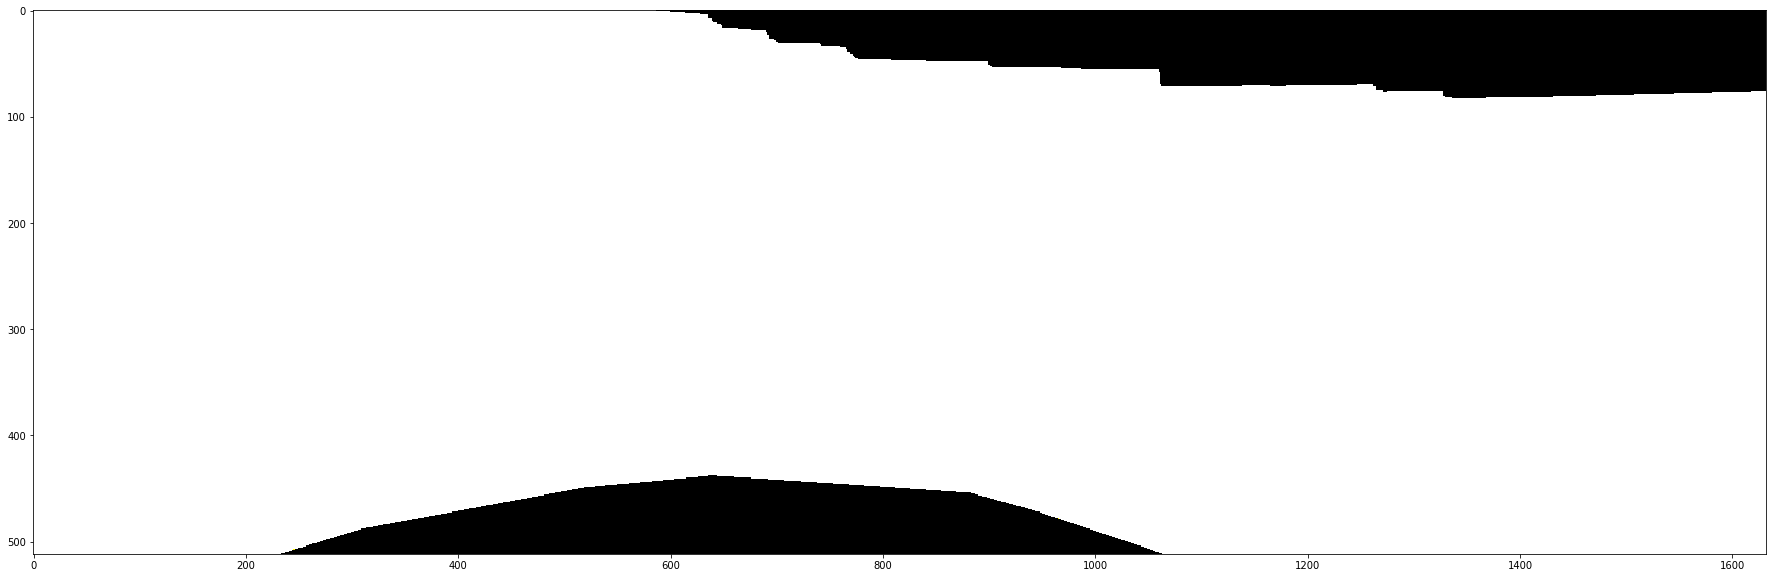

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import statistics
import pdb

# for each pixel, find the median across the 900 frames
# vectorized approach
ht, wd = projected[0].shape[0], projected[0].shape[1]
median_calc = np.zeros((ht,wd,3,len(projected)))
median_calc.fill(np.nan)

frame,x,y,c = np.nonzero(projected)
median_calc[x,y,c,frame] = projected[frame,x,y,c]
median = np.nanmedian(median_calc,axis=3)

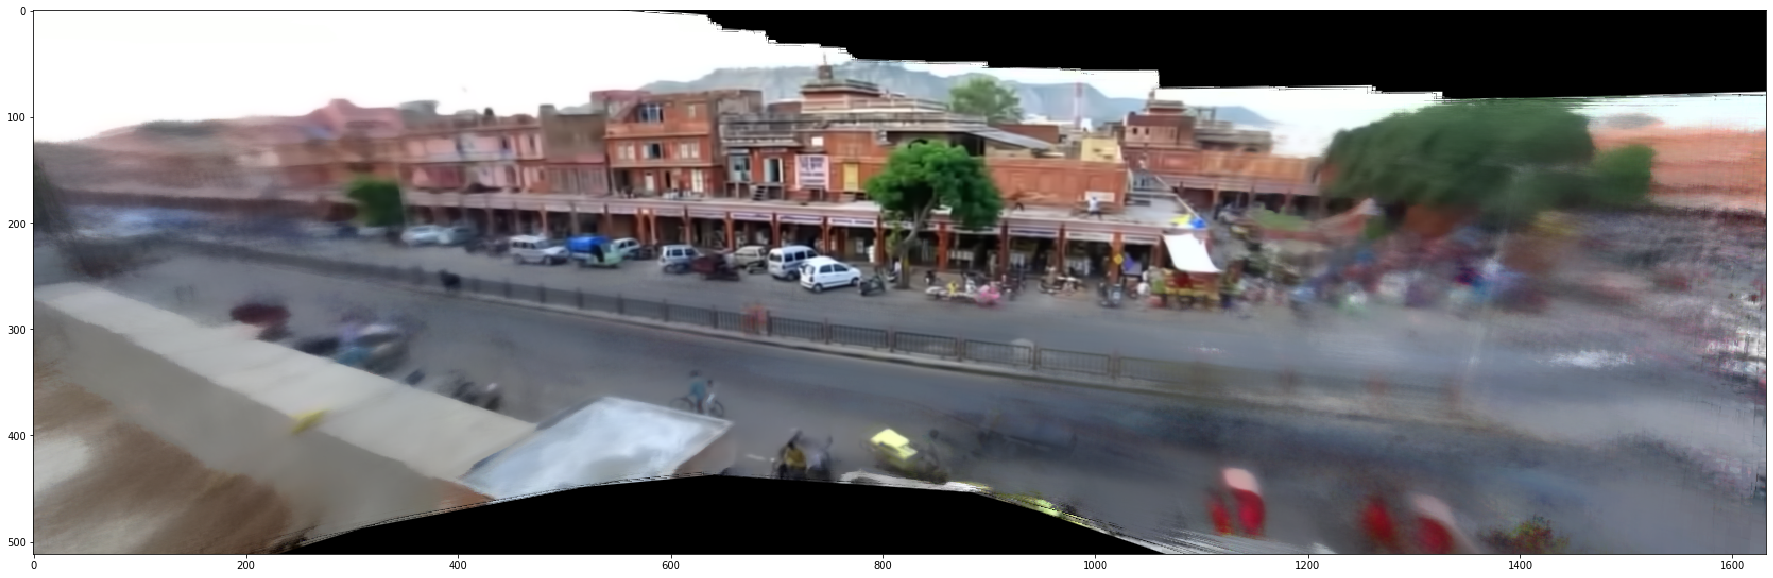

In [26]:
plt.figure(figsize=(60,10))
plt.imshow(median/255)

### Part 5: Create background movie

Map the background panorama to the movie coordinates. For each frame of the movie, say frame 1, you need to estimate a projection from the panorama to frame 1. Note, you should be able to re-use the homographies that you estimated in __Part 3__. Perform this for all frames and generate a movie that looks like the input movie but shows only background pixels. All moving objects that belong to the foreground must be removed.

In [10]:
import os
import cv2
import numpy as np

#Go through all past homographies

for i in range(0, 2):
    cur_H = pastHomographies[i][450]
    print(cur_H.shape)
    inv_H = np.linalg.inv(cur_H)
    img_warped = cv2.warpPerspective(median, inv_H, (360, 480))

NameError: name 'pastHomographies' is not defined

In [32]:
utils.imageFolder2mpeg('out5', fps=30)

IndexError: list index out of range

### Part 6: Create foreground movie

In the background video, moving objects are removed. In each frame, those pixels that are different enough than the background color are considered foreground. For each frame determine foreground pixels and generate a movie that only includes foreground pixels.

In [33]:
import os
import cv2
import numpy as np

for i in range(0, 900):
    difference = frames[i] - (warped_imgs[i]/255)
    cv2.imwrite('part6_frames/a{:04d}.jpg'.format(i), difference*255)

NameError: name 'warped_imgs' is not defined

In [ ]:
utils.imageFolder2mpeg('out6', fps=30)

## Bells and whistles